In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

df = pd.read_csv('inferences.csv', sep=',', index_col=0)
noises = df['NOISE'].drop_duplicates().tolist()
datasets = df['DATASET'].drop_duplicates().tolist()
models = df['MODEL'].drop_duplicates().tolist()
df

,NOISE,DATASET,MODEL,ERR_AVG,ERR_STD,ERR_MAX,ERR_MIN,LOG_STD
0,0.0,SIMULATION_00_03,PIDNN_200,0.000072,7.137928e-05,0.000173,0.000021,0.975969
1,0.0,SIMULATION_00_03,PIDNN_400,0.000018,8.675345e-07,0.000019,0.000017,0.047634
2,0.0,SIMULATION_00_03,PIDNN_800,0.000018,1.849060e-06,0.000020,0.000016,0.101243
3,0.0,SIMULATION_00_03,PIDNN_1600,0.000016,2.363793e-07,0.000016,0.000015,0.115293
4,0.0,SIMULATION_00_03,FF_200,0.003097,3.241646e-03,0.007659,0.000428,1.193453
...,...,...,...,...,...,...,...,...
115,0.1,SIMULATION_00_40,PIDNN_1600,0.000148,0.000000e+00,0.000148,0.000148,0.100000
116,0.1,SIMULATION_00_40,FF_200,0.005704,2.932414e-03,0.009834,0.003315,0.476124
117,0.1,SIMULATION_00_40,FF_400,0.002916,8.088547e-04,0.003676,0.001795,0.314183
118,0.1,SIMULATION_00_40,FF_800,0.001914,7.255997e-04,0.002725,0.000964,0.438649


In [2]:
def plot_setup(dimr, dimc, xlabel, suptitle, ylim, hide_last=False, height=10.5):
    fig, axs = plt.subplots(dimr, dimc, sharey=True)
    fig.set_size_inches(18.5, height)
    fig.set_dpi(100)
    plt.ylim(0, ylim)  
    fig.suptitle(suptitle, fontsize=24)
    for ax in axs.flat:
        ax.set(xlabel=xlabel, ylabel='-log(relative MSE)')
        ax.label_outer()
        # ax.spines["top"].set_visible(False)  
        # ax.spines["right"].set_visible(False)  
        ax.get_xaxis().tick_bottom()  
        ax.get_yaxis().tick_left() 
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.yaxis.set_tick_params(labelleft=True)
        ax.grid(color='0.90')
    if hide_last: axs.flat[-1].set_visible(False)
    return fig, axs

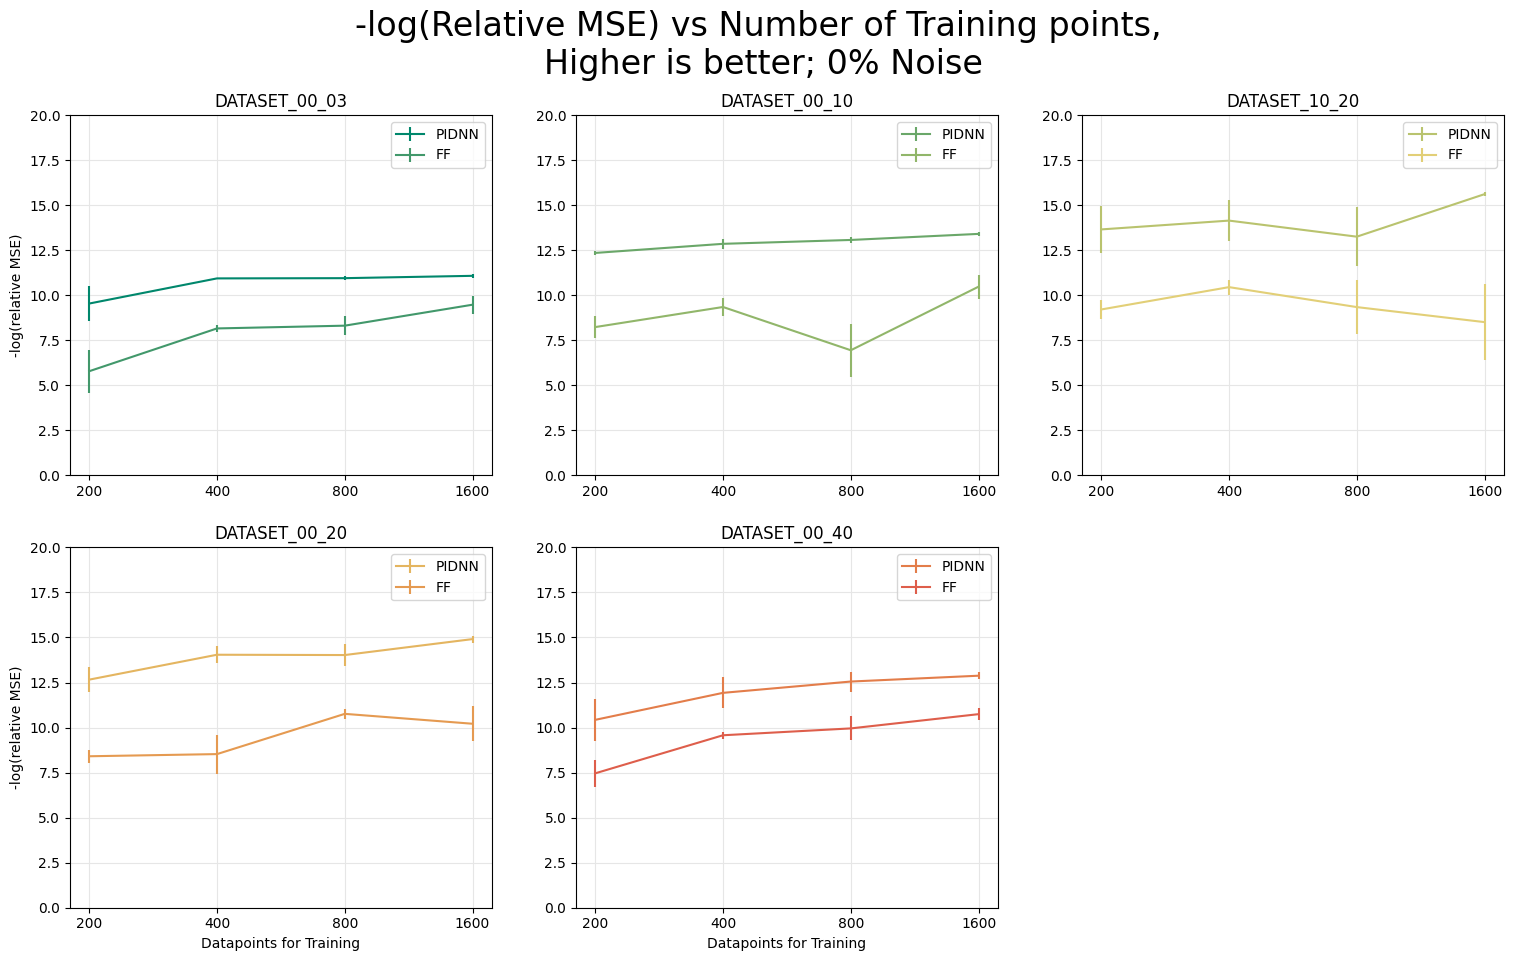

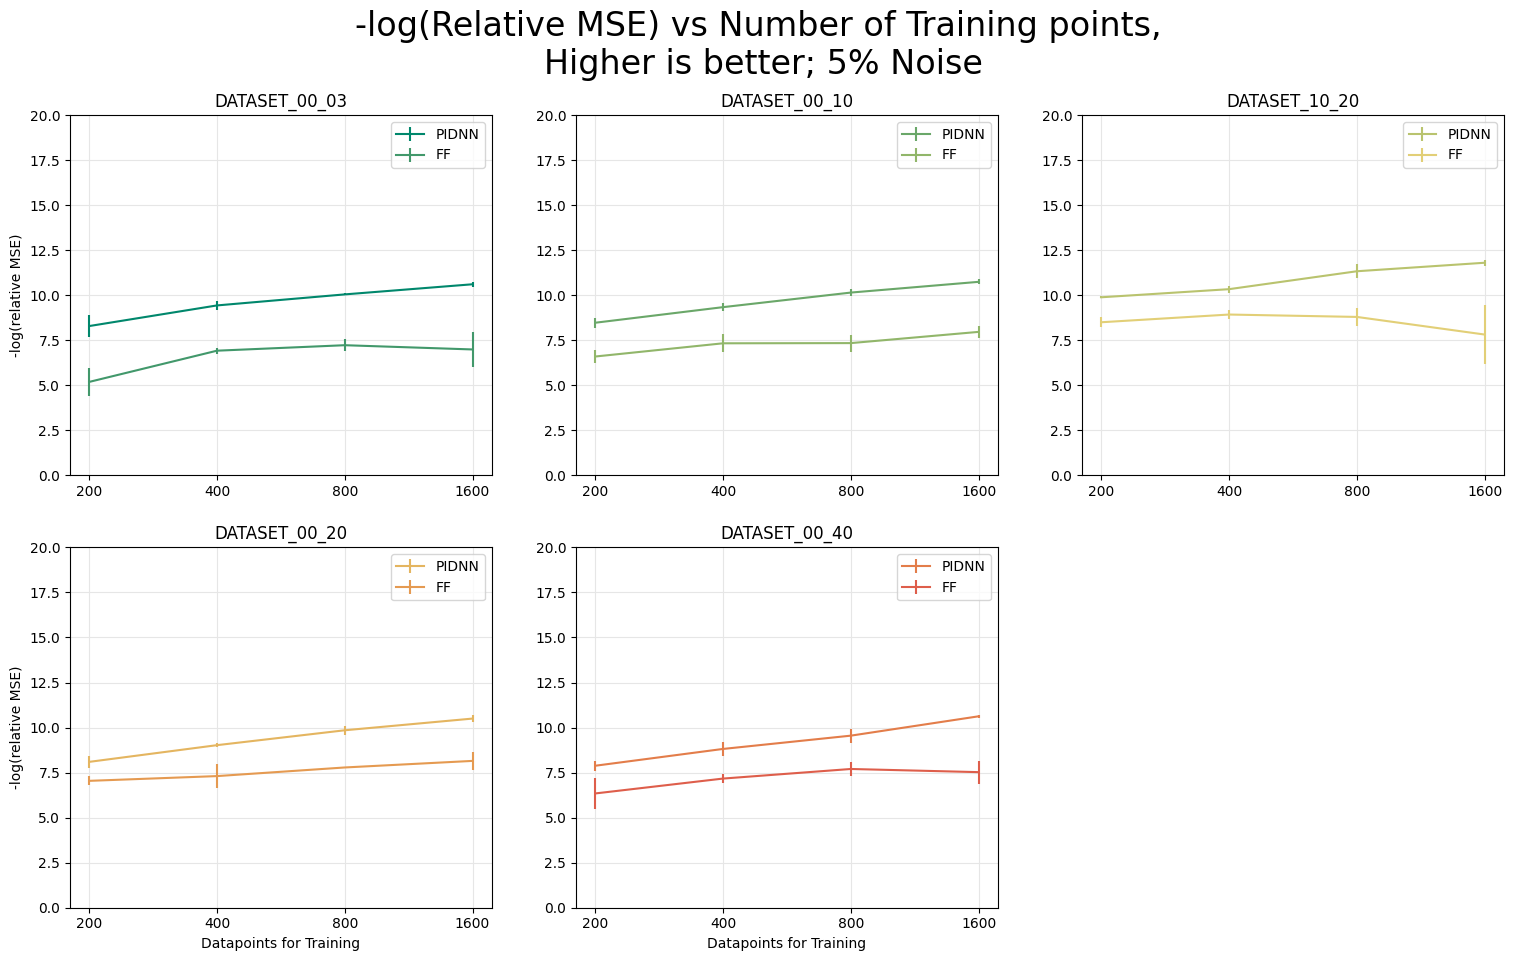

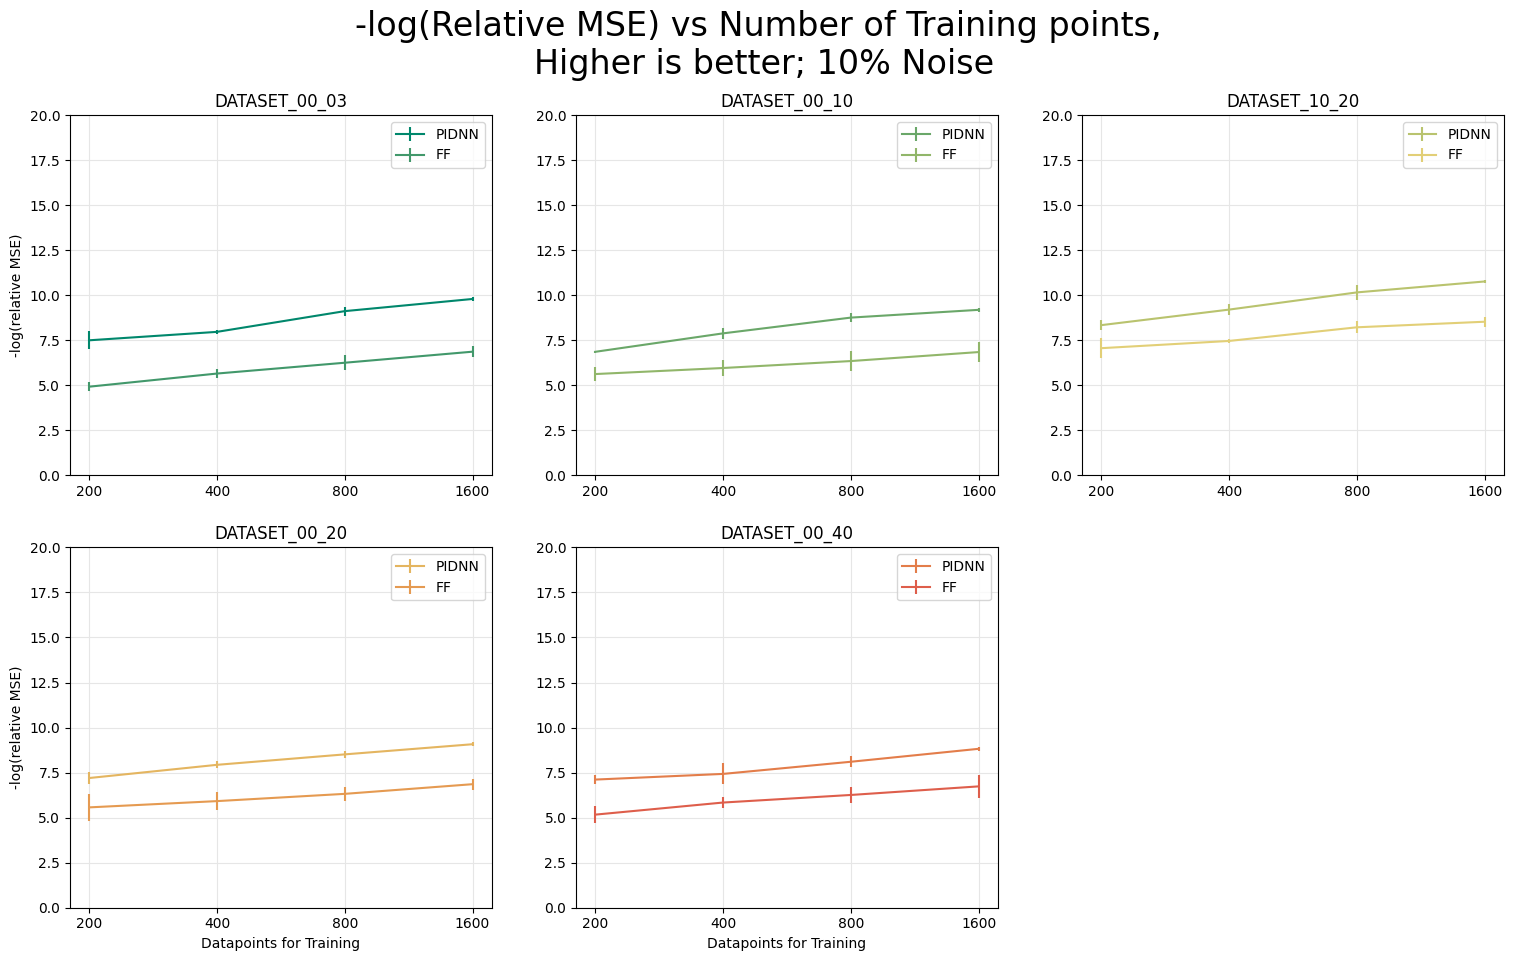

In [3]:
colors = ["#00876c","#42986b","#6aa769","#91b66a","#b9c36e","#e2cf77","#e4b560","#e59a51","#e37d4a","#de5e4b","#d43d51"]

for noise in noises:
    color_iter = 0

    fig, axs = plot_setup(2, 3, xlabel='Datapoints for Training', suptitle=f'-log(Relative MSE) vs Number of Training points, \nHigher is better; {int(100*noise)}% Noise', ylim=20, hide_last=True)
    
    for ind, dataset in enumerate(datasets):
        rdf = df.loc[(df['NOISE'] == noise) & (df['DATASET'] == dataset)]

        x = [s.split('_')[-1] for s in rdf['MODEL'].tolist()]

        for nn in ['PIDNN','FF']:
            y = np.array(rdf.loc[rdf['MODEL'].str.startswith(nn), 'ERR_AVG'].tolist())
            yerr = np.array(rdf.loc[rdf['MODEL'].str.startswith(nn), 'LOG_STD'].tolist())

            axs[ind//3, ind%3].errorbar(x[:y.shape[0]], -np.log(y), yerr = yerr,
                        label =nn, color=colors[color_iter])
            color_iter = (color_iter + 1)%len(colors)
        
        axs[ind//3, ind%3].legend(loc ='upper right')

        dataset_replaced = dataset.replace('SIMULATION', 'DATASET')
        axs[ind//3, ind%3].set_title(f'{dataset_replaced}')
        fig.show()

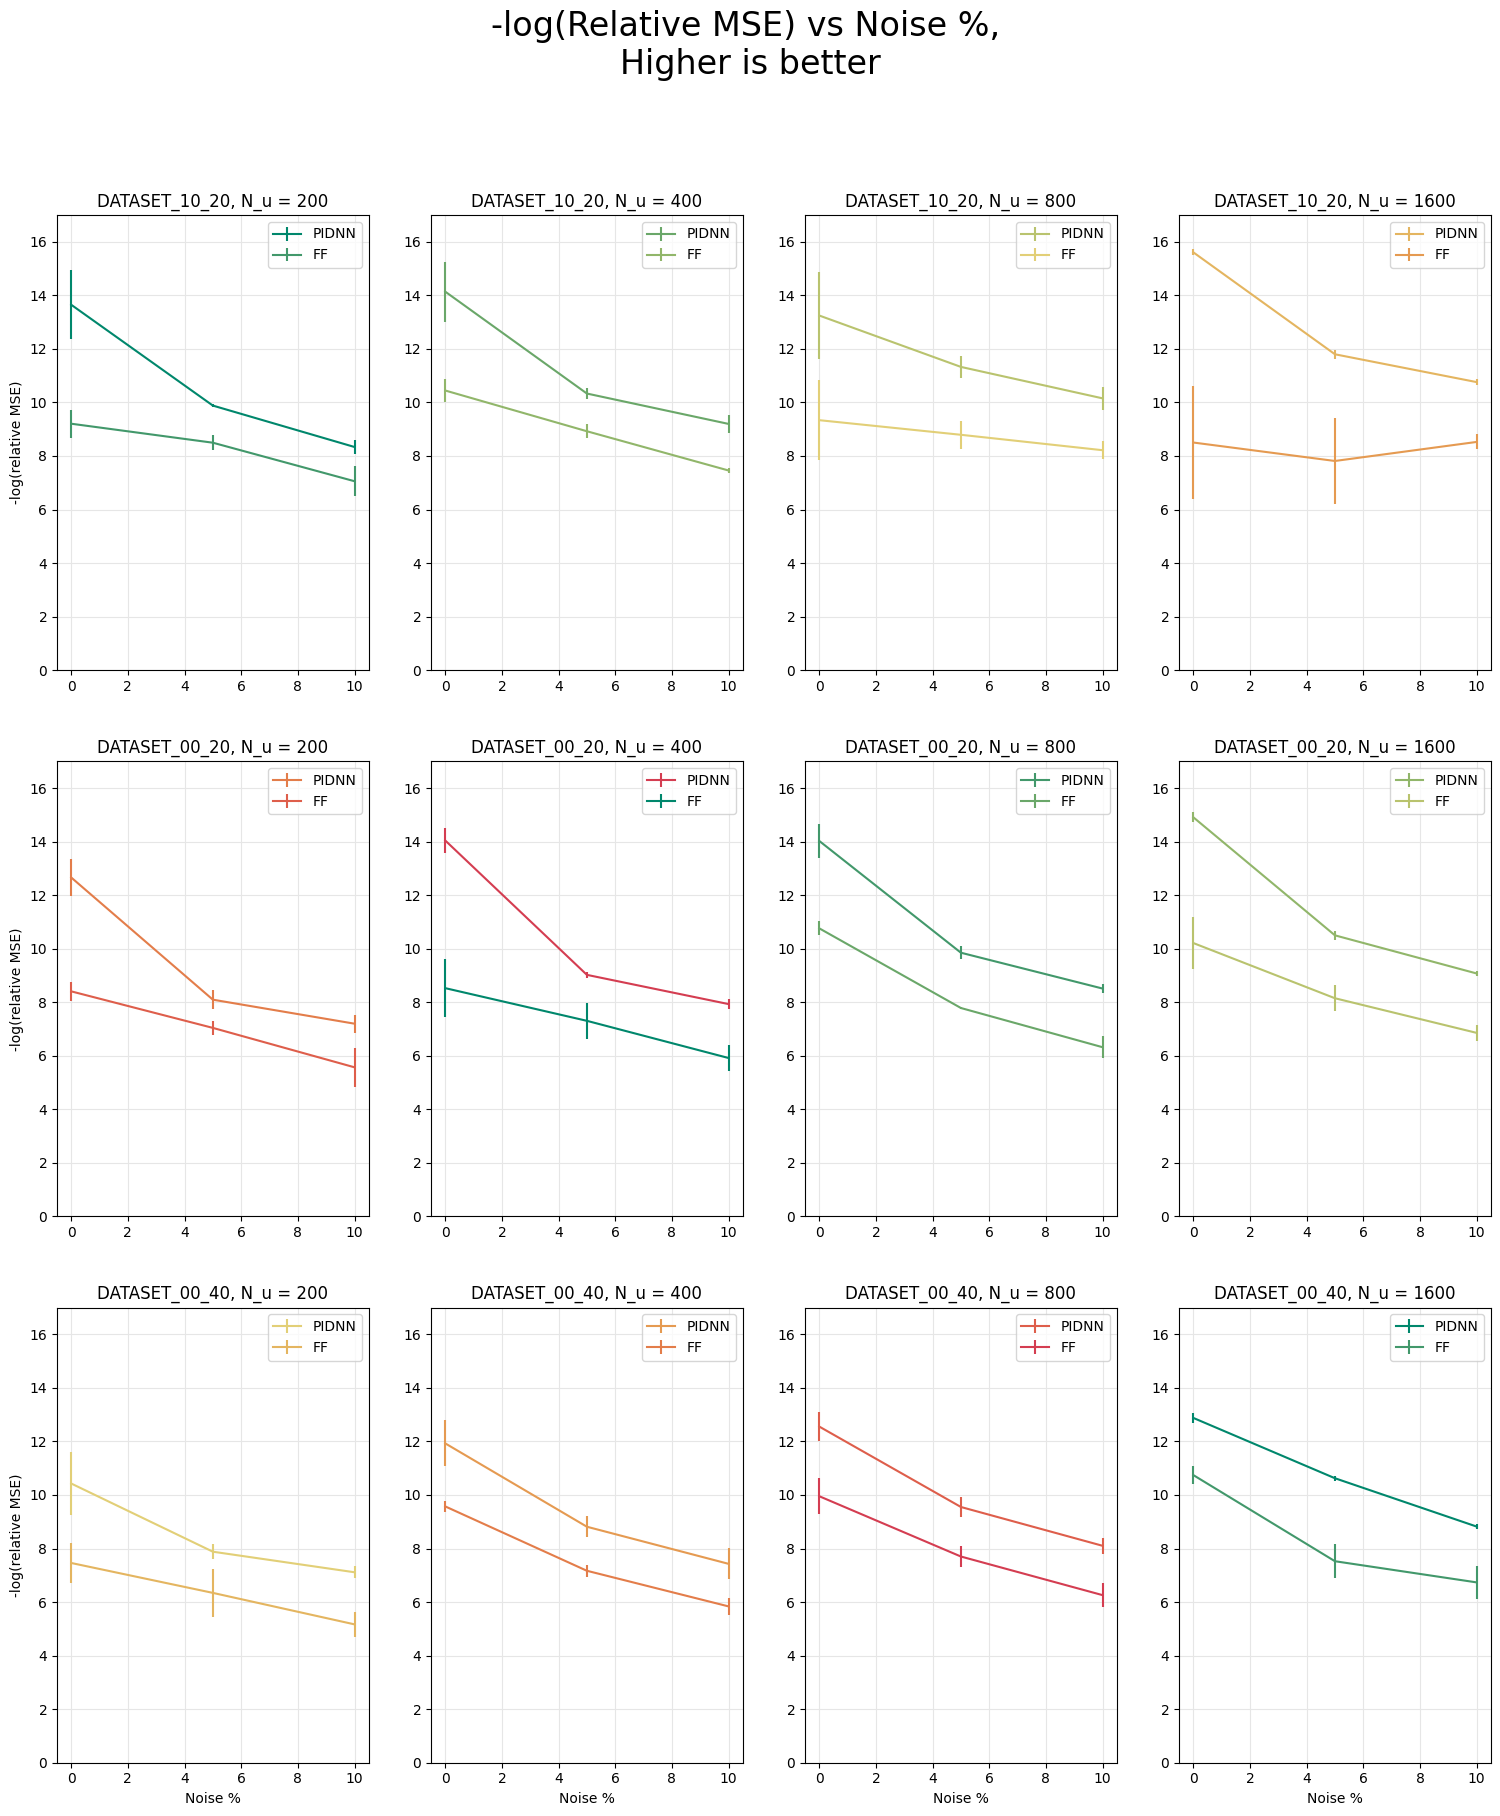

In [4]:
colors = ["#00876c","#42986b","#6aa769","#91b66a","#b9c36e","#e2cf77","#e4b560","#e59a51","#e37d4a","#de5e4b","#d43d51"]
possible_Nu = list(set([int(s.split('_')[-1]) for s in models]))
possible_Nu.sort() # N_u = number of data points
possible_Nu = [str(s) for s in possible_Nu]

color_iter = 0

representative_datasets = datasets[-3:]

fig, axs = plot_setup(len(representative_datasets), len(possible_Nu), xlabel='Noise %', suptitle=f'-log(Relative MSE) vs Noise %, \nHigher is better', ylim=17, height=20.5)

for indr, dataset in enumerate(representative_datasets):
    for indc, Nu in enumerate(possible_Nu):
        rdf = df.loc[(df['DATASET'] == dataset) & (df['MODEL'].str.endswith(f'_{Nu}'))]
        x = [100*n for n in noises]

        for nn in ['PIDNN','FF']:
            y = np.array(rdf.loc[rdf['MODEL'].str.startswith(nn), 'ERR_AVG'].tolist())
            yerr = np.array(rdf.loc[rdf['MODEL'].str.startswith(nn), 'LOG_STD'].tolist())

            axs[indr][indc].errorbar(x[:y.shape[0]], -np.log(y), yerr = yerr,
                        label =nn, color=colors[color_iter])
            color_iter = (color_iter + 1)%len(colors)
        
        axs[indr][indc].legend(loc ='upper right')

        dataset_replaced = dataset.replace('SIMULATION', 'DATASET')
        axs[indr][indc].set_title(f'{dataset_replaced}, N_u = {Nu}')

fig.show()

In [5]:
model = 'PIDNN_1600'.lower()

lin_tables = dict({})
for dataset in datasets:
    for noise in noises:
        noise = int(100*noise)
        df = pd.read_csv(f'../Models/SEED_1234/Noise_{noise}/{dataset.lower()}/{model}.csv', sep=',', index_col=0)
        df.loc[df['Validation Error']>0.1, 'Validation Error'] = np.NAN

        cm = (df['N_f']/df['N_u']).drop_duplicates().tolist()
        cm = [str(c) for c in cm]
        alphas = df['alpha'].drop_duplicates().tolist()
        alphas = [str(a) for a in alphas]

        lin_table = np.array(df['Validation Error'].tolist()).reshape(len(cm),-1)
        lin_table = -np.log(lin_table)
        lin_tables[(dataset,noise)] = lin_table

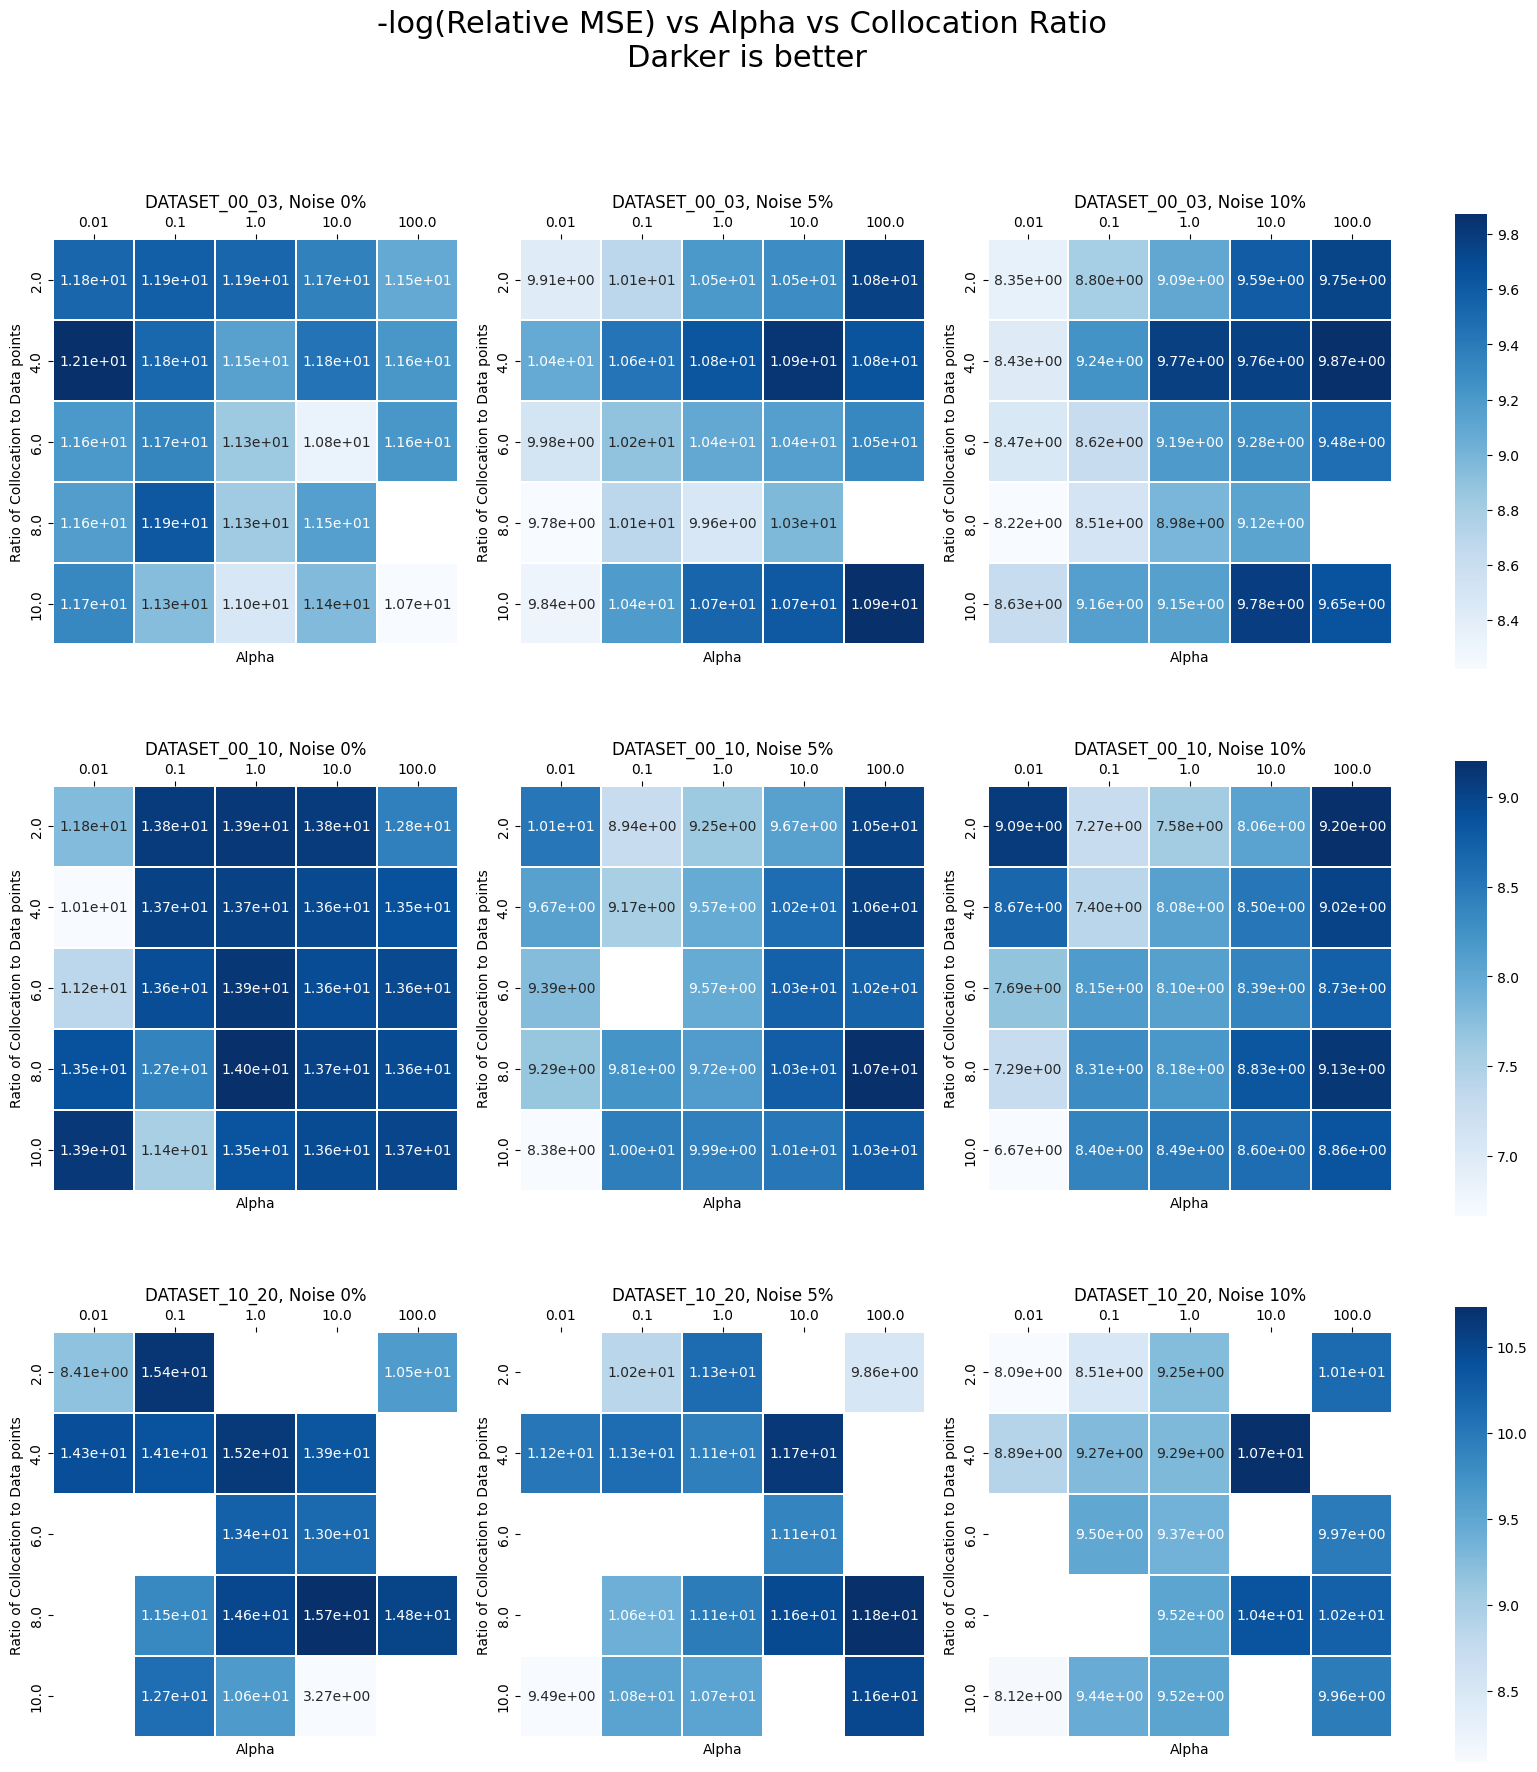

In [6]:
interested_datasets = datasets[:3]

f, ax = plt.subplots(len(interested_datasets),4, 
        gridspec_kw={'width_ratios':[1,1,1,0.08]}, )
f.set_size_inches(18.5, 20.5)
f.set_dpi(100)
f.suptitle('-log(Relative MSE) vs Alpha vs Collocation Ratio \nDarker is better', fontsize=22)

for axs in ax.flat:
    axs.xaxis.tick_top()

for indr, dataset in enumerate(interested_datasets):
    dataset_name = dataset.replace('SIMULATION', 'DATASET')
    ax[indr][0].get_shared_y_axes().join(ax[indr][1], ax[indr][2])
    g1 = sb.heatmap(lin_tables[(dataset, 0)],cmap="Blues",square=True,
                linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, fmt=".2e", cbar=False, ax=ax[indr][0])
    g1.set_title(f'{dataset_name}, Noise 0%')

    g2 = sb.heatmap(lin_tables[(dataset, 5)],cmap="Blues",square=True,
                linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, fmt=".2e", cbar=False, ax=ax[indr][1])
    g2.set_title(f'{dataset_name}, Noise 5%')

    g3 = sb.heatmap(lin_tables[(dataset, 10)],cmap="Blues",square=True,
                linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, fmt=".2e", ax=ax[indr][2], cbar_ax=ax[indr][3])
    g3.set_title(f'{dataset_name}, Noise 10%')
    
    for g in [g1,g2,g3]:
        g.set_ylabel('Ratio of Collocation to Data points')
        g.set_xlabel('Alpha')
        g.set_yticklabels(cm)
        g.set_xticklabels(alphas)



plt.show()